

**<font color = 'green'>*Prueba Machine Learning - Prediciendo precios de vuelos*</font>**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Preparacion modelos
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector

# Metricas evaluacion
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# Test estadisticos
from scipy import stats
from scipy.stats import f_oneway

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.Describe con detenimiento el problema de negocio que se desea resolver, y cómo se va a hacer esto. Indica la metodología, tareas a realizar, variable objetivo a predecir, etc.

Respuesta: El problema de negocio a resolver es desarrollar un MVP con el cual los clientes de la agencia de viajes, a través de la misma, puedan encontrar con precision el valor de los boletos de sus viajes a futuro, pudiendo ser tanto de la clase economy o businnes. El target objetivo al ser una variable numerica, nos posiciona frente a un problema del tipo regresivo, por lo cual tendremos que en primera instancia ejecutar una correcta limpieza y transformación de variables (nulos,outliers, erroneos,etc) , para luego a través de metodos estadisticos como analisis de correlaciones y test de ANOVA para definir que features son estadisticamente signficativas para lograr predecir el precio de los boletos a futuro. Luego de esa primera seleccion de features, se realizará un modelo base sobre el cual se iterará a través de validación cruzada/gridsearch, con el objetivo de encontrar las mejores combinaciones de hiperparametros para lograr el mejor rendimiento en evaluación, los cuales compararemos a través de r2, RMSE, MSE, etc.

Una de las condiciones importantes a indicar, es que se trabajarán ambos datasets por separados en el preprocesamiento y analisis exploratorio de datos,  ya que por el contexto del negocio, son productos distintos y si se unen, se puede perder la granuralidad de entender cuanto puede variar cada producto a futuro, además de que los estadísticos de cada clase de boleto se verán afectados por el otro.Esto asegura que cada modelo pueda capturar las características únicas asociadas con cada tipo de precio si el boleto es business o economy, por ejemplo, si se unen en un dataset y se limpian outliers, se eliminarian valores que no son outliers, si no que simplemente corresponden a los precios de la otra clase. Para el modelamiento tambien se ejecutarán de manera distinta, privilegiando los hiperparametros de la clase con más datos.

Tentativamente algunos de los modelos a testear serán Regresion lineal multiple, series de tiempo arima/autoarima, SVM o arboles de decision regresores, sin embargo favor remitirse a los testeados en el punto 7.

# 2.Carga los dataset entregados y genera un reporte de calidad. | 3.Genera un análisis exploratorio de los dataset entregados, un análisis univariado y bivariado.

In [ ]:
# Cargamos ambos df
df_businnes_raw = pd.read_excel(
    "/content/drive/My Drive/Colab Notebooks/Machine Learning/9.Prueba/business.xlsx")
df_economy_raw = pd.read_excel(
    "/content/drive/My Drive/Colab Notebooks/Machine Learning/9.Prueba/economy.xlsx")

In [ ]:
df_businnes_raw.head()  # Visualizamos los primeros registros de businesss

In [ ]:
df_economy_raw.head()  # Visualizamos los primeros registros de economy

**<font color = 'green'>*Revision de calidad de datos*</font>**

In [ ]:
def data_quality(df, df_name):
    # Dimension
    print("======= Revision de dimension ==========")
    print("")
    print(f"El shape de {df_name} es {df.shape}")
    print("")
    # Revision de valores nulls
    print("======= Revision de nulos ==========")
    print("")
    print(f"Cantidad de nulos por columna en el dataset {df_name}:")
    print("")
    for colname in df.columns:
        col_nulls = df[colname].isna().sum()
        print(f"{colname}: {col_nulls}")
    print("")

    # Revision dtypes
    print("")
    print("======= Revision dtypes ==========")
    print("")
    print(df.dtypes)

    # Revision de duplicados
    print("")
    print("======= Revision duplicados ==========")
    print("")
    print(f"Cantidad de duplicados en {df_name} : {df.duplicated().sum()}")

    # Revision de valores unicos, con esto podemos ver si las variables categoricas presentan valores erroneos, ya que los outliers solo aplican para numericas.
    print("")
    print("======= Revision valores unicos ==========")
    print("")
    for colname in df.columns:
        col_nunique = df[colname].nunique()
        print(f"{colname}: {col_nunique}")
    print("")

    # Valores unicos variables categoricas
    print("")
    print("======= Revision valores unicos categoricas ==========")
    print("")
    for colname in df.columns:
        if df[colname].dtypes not in ["int", "float"]:
            col_unique = df[colname].unique()
            print(f"Columna {colname}:")
            print("")
            print(col_unique)
            print("")

Ejecutamos la funcion para ambos datasets

In [ ]:
data_quality(df_businnes_raw, "Businnes")

In [ ]:
data_quality(df_economy_raw, "Economy")

La primera revision de calidad de datos nos informa que ambos dataset no presenta valores nulos, pero si 2 duplicados en economy, los que se dropearán al no ser significativos. Con respecto a los dtypes, apreciamos que el target, osea Price, en businnes está en string, por lo que debemos transformarlo a integer. En general no se aprecian diferencias notables entre ambos dataset a nivel de estructura, más alla de que business contiene menos data, por lo que aplicaremos la siguiente funcion de preprocesamiento, la cual se encuentra documentada y revela paso a paso lo que se realiza.

**<font color = 'green'>*Transformación de datos antes de la visualización*</font>**

In [ ]:
def get_df_clean(df):
    # Primero dropeamos los nulos y duplicados si los hay
    df = df.dropna()
    df = df.drop_duplicates()
    for colname in df.columns:
        # Transformamos num code
        if colname in ["num_code", "ch_code"]:
            df[colname] = df[colname].astype(str)

            # Transformamos dep_time y arr time
        elif colname in ["arr_time", "dep_time"]:
            # Primero solo dejamos las horas y minutos en ambas columnas
            df[colname] = df[colname].apply(lambda x: x.strftime("%H:%M"))

            # Transformamos time taken para tranformarla a minutos
        elif colname == "time_taken":
            # Hacemos un replace de la h y la m dentro de la cadena a través de una expresión regular
            df[colname] = df[colname].str.replace(
                "[hm]", "", regex=True).astype(str)
            # Extraemos las horas y los minutos utilizando una expresión regular
            time_extracted = df[colname].str.extract(r'(\d+) (\d+)').fillna(0)
            # Convertimos los valores extraídos a enteros
            df["tk_hours"] = time_extracted[0].astype(int)
            df["tk_mins"] = time_extracted[1].astype(int)
            # Calculamos el tiempo total de viaje en horas decimales
            df["time_taken_hrs"] = round(
                df["tk_hours"] + (df["tk_mins"] / 60), 2)

            # Transformamos price a numerico
        elif colname == "price":
            df[colname] = df[colname].replace(",", ".")
            df[colname] = pd.to_numeric(df[colname], errors="coerce")
            df = df.dropna(subset=[colname])
            df[colname] = df[colname].astype(int)

            # Transformamos la columna stop, eliminando los caracteres erroneos
        elif colname == "stop":
            # Extraemos solo los numeros de paradas
            df[colname] = df[colname].str.extract(r'(\d+)', expand=False)
            # Rellenamos los NaN, que pertenecian  Non_stop, para dejarlos en 0
            df[colname] = df[colname].fillna(0)

            # Creamos fly code, el cual será nuestra PK
    if ("ch_code" in df.columns) and ("num_code" in df.columns):
        df["fly_code"] = df["ch_code"] + "-" + df["num_code"]

    df = df.drop(columns=["ch_code", "num_code",
                 "time_taken", "tk_hours", "tk_mins"])

    return df

In [ ]:
# Llamamos a la funcion para limpiar ambos df
df_businnes = get_df_clean(df_businnes_raw)
df_economy = get_df_clean(df_economy_raw)

**<font color = 'green'>*Visualizamos antes de limpiar outliers*</font>**

Solo seleccionamos las caracteristicas más relevantes para graficos uni y bi variante.

In [ ]:
# Filtramos las caracteristicas importantes
busi_vis = df_businnes.drop(
    columns=["fly_code", "dep_time", "date", "arr_time"])
eco_vis = df_economy.drop(columns=["fly_code", "dep_time", "date", "arr_time"])

In [ ]:
def get_graphics_uni(df, df_name):  # Funcion para crear graficos univariables
    print(f"Graficos del dataset {df_name}:")
    print("")
    fix, axs = plt.subplots(2, 3, figsize=(20, 8))

    for index, colname in enumerate(df.columns):
        if df[colname].dtypes == "object":  # Si son categoricas, count plot
            # Calculamos frequencia promedio
            freq = df[colname].value_counts()
            prom_freq = freq.mean()  # Promedio freq

            plt.subplot(2, 3, index+1)
            sns.countplot(df[colname], alpha=0.3, lw=0.5, color="grey")
            plt.axvline(prom_freq, lw=0.5, ls="dashed", color="red",
                        label=f"Mean {round(prom_freq,2)}")

            plt.title(f"Frecuencia {colname}")
            plt.legend(loc="upper center")
            plt.tight_layout()
        else:  # Si son numericas haremos boxplot para ver su distribución
            plt.subplot(2, 3, index+1)
            sns.boxplot(x=df[colname], orient="horizontal", width=0.4,
                        boxprops=dict(facecolor="skyblue", alpha=0.3),
                        flierprops=dict(markerfacecolor='grey', markeredgecolor='grey', marker="x", linewidth=1))
            plt.axvline(df[colname].mean(), lw=0.5, ls="dashed",
                        color="red", label=f"Mean {round(df[colname].mean(),2)}")
            plt.legend(loc="upper center")
            plt.title(f"Distribución {colname}")
            plt.tight_layout()

In [ ]:
# Visualizamos Business
get_graphics_uni(busi_vis, "Business")

In [ ]:
# Este codigo es solo para calcular porcentajes que sirven para apoyar los insights del grafico superior.No es necesario arrancar
for col in busi_vis:
    print(f"Porcentaje frecuencia en {col}: ")
    print(busi_vis[col].value_counts("%"))
    print("")

**<font color = 'green'>*Descubrimientos analisis univariado business*</font>**




*   Solo se detectan 2 aerolineas que cuentan con boletos para business, de los cuales, un 65% pertenecen a Vistara.
*   Con respecto a las ciudades desde donde despega el vuelo, existen solo 6 ciudades distintas, destacando a Delhi, Mumbai y Bangalore, sin embargo la distribución de la frecuencia entre estas categorías no pareciera ser muy distinta
*   Aproximadamente un 90% de los viajes de business cuentan con al menos una parada, seguido de 0 paradas.
*   Con respecto a “To”, como destinos, se repiten las mismas ciudades y en sus frecuencias no destacan considerablemente unas sobre otras.
*   Sobre precio, el 50% de los boletos del dataset sobre business, se encuentran entre el rango de 45.000 a 60.000$, presentando también bastantes outliers tanto inferiores como superiores, llegando incluso a valores de 100k.
*   La distribución de horas totales que toma el vuelo en business, cuenta con un 50% de los valores entre 10 a 18hrs aprox, teniendo como limite superior 32 horas y también cuenta con muchos outliers que alcanzan 50hrs inclusive.



Graficos del dataset Economy:



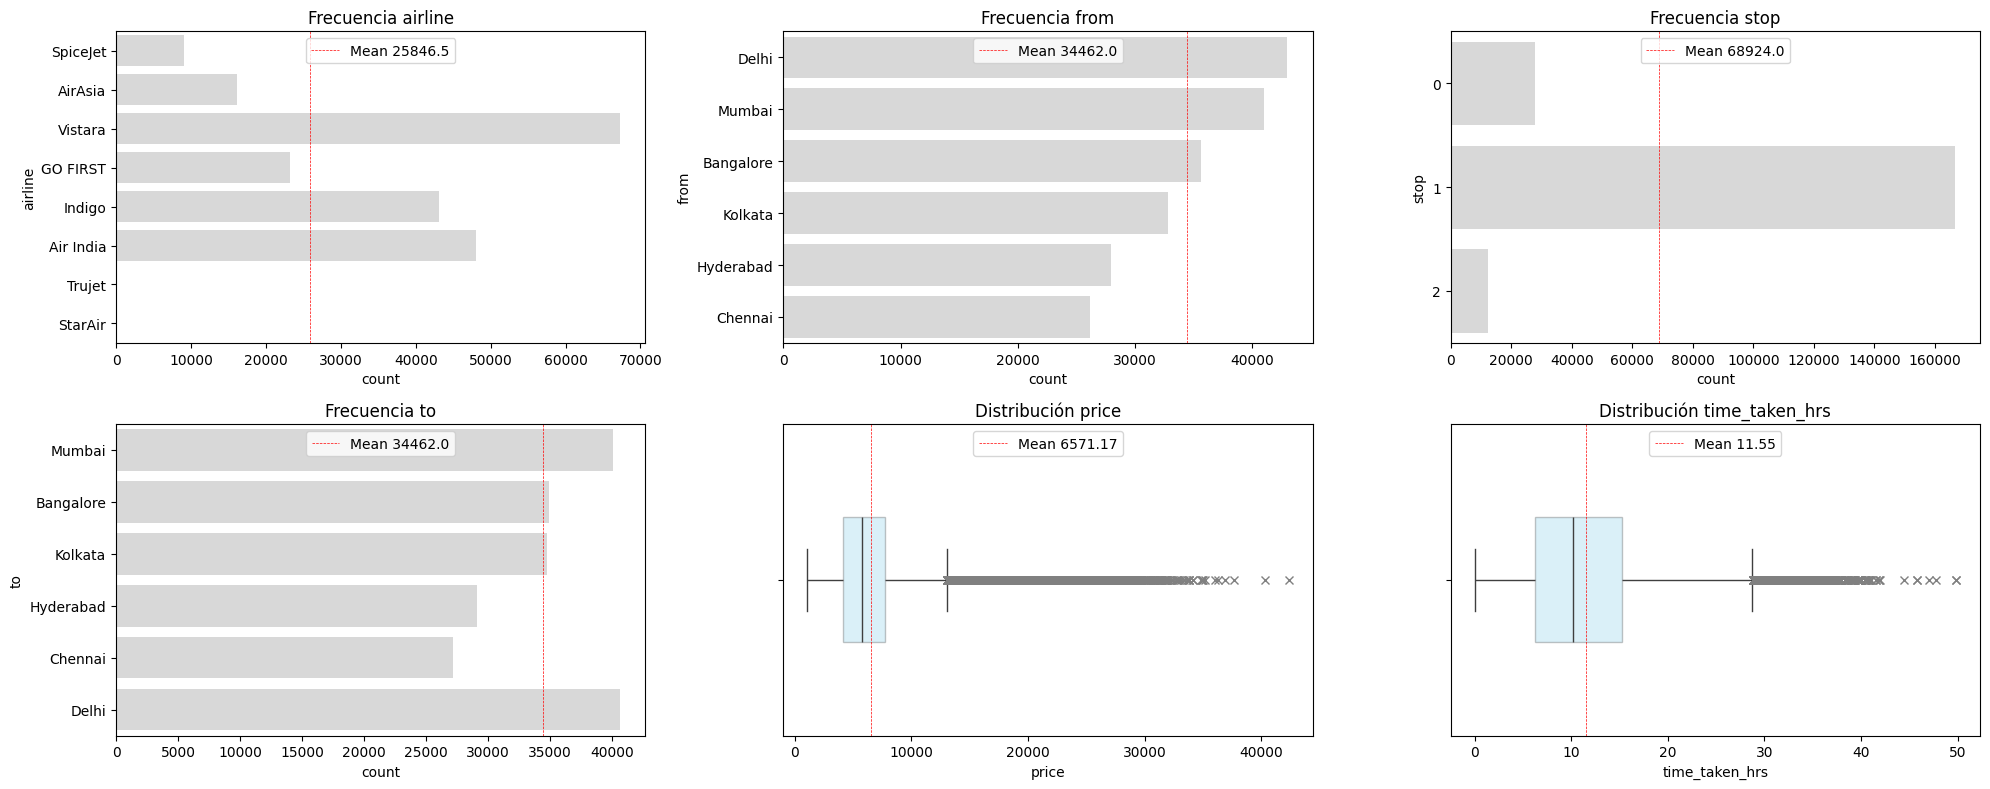

In [ ]:
# Visualizamos Economy
get_graphics_uni(eco_vis, "Economy")

**<font color = 'green'>*Descubrimientos analisis univariado economy*</font>**

In [ ]:
# Este codigo es solo para calcular porcentajes que sirven para apoyar los insights del grafico superior. No es necesario arrancar
for col in eco_vis:
    print(f"Porcentaje frecuencia en {col}: ")
    print(eco_vis[col].value_counts("%"))
    print("")




*   A diferencia de business, en economy tenemos mayor cantidad de aerolíneas que prestan servicios a esta clase, llegando a 8 lineas, de las cuales se destacan Vistara con un 32%, Air India con un 23% e Indigo con un 20%. Por lo tanto, Vistara y Air India son aerolíneas relevantes en los viajes entre estos destinos del mundo ya que esta abarcando ambos modelos de negocios.
*   Con respecto a las ciudades desde donde despega el vuelo, no se percibe distinta a business.
*   Aproximadamente un 80% de los viajes de business cuentan con al menos una parada, seguido de 0 paradas, pero en este segmento, las 2 paradas alcanzan un 6%, en comparación con un 0% en business.
*   Con respecto a “To”, como destinos, se repiten los mismos patrones generales que en business.
*   Sobre precio, con un promedio casi 45.000$ más bajo, podemos apreciar que se distribuye de manera sesgada a la derecha, distribuyendo el 50% de los datos entre el rango de 4000 a 8000 aproximadamente. Lo cual es notablemente distinto a business. Además de esto, el mismo sesgo hace que esta variable tenga excesivos outliers por sobre el limite superior.
*   La distribución de horas totales que toma el vuelo en economy, solo baja 2 hrs en promedio con respecto a business. Y en general distribuyen de manera similar, esto puede deberse a que en si, la diferencia entre business y economy recae principalmente en la zona del avión y no necesariamente en otras variables como la velocidad de los vuelos, ya que son las mismas distancias y los mismos aviones, por lo que era esperable encontrarse con distribuciones similares


**<font color = 'green'>*Analisis multivariante Business*</font>**

Consideraremos para el analisis multivariable compara como se comporta price y time taken contra las demas variables categoricas, para ver si existen diferencias notables entre ellas.

In [ ]:
def get_graph_bi(df, df_name):
    print(f"Graficos del dataset {df_name}:")
    print("")
    fix, axs = plt.subplots(2, 4, figsize=(23, 10))

    # Airline-price
    sns.boxplot(data=df, x="airline", y="price", hue="airline", ax=axs[0, 0], orient="vertical", width=0.5, boxprops=dict(alpha=0.3),
                flierprops=dict(markerfacecolor='grey', markeredgecolor='grey', marker="x", linewidth=1))
    # From-price
    sns.boxplot(data=df, x="from", y="price", hue="from", ax=axs[0, 1], width=0.6, boxprops=dict(alpha=0.3),
                flierprops=dict(markerfacecolor='grey', markeredgecolor='grey', marker="x", linewidth=1))
    # Stops-price
    sns.boxplot(data=df, x=df["stop"].astype(object), y="price", hue="stop", ax=axs[0, 2], width=0.6, boxprops=dict(alpha=0.3),
                flierprops=dict(markerfacecolor='grey', markeredgecolor='grey', marker="x", linewidth=1))
    # To (destino) -price
    sns.boxplot(data=df, x="to", y="price", hue="to", ax=axs[0, 3], width=0.6, boxprops=dict(alpha=0.3),
                flierprops=dict(markerfacecolor='grey', markeredgecolor='grey', marker="x", linewidth=1))

    # Airline-time_taken
    sns.boxplot(data=df, x="airline", y="time_taken_hrs", hue="airline", ax=axs[1, 0], orient="vertical", width=0.5, boxprops=dict(alpha=0.3),
                flierprops=dict(markerfacecolor='grey', markeredgecolor='grey', marker="x", linewidth=1))
    # From-time_taken
    sns.boxplot(data=df, x="from", y="time_taken_hrs", hue="from", ax=axs[1, 1], width=0.6, boxprops=dict(alpha=0.3),
                flierprops=dict(markerfacecolor='grey', markeredgecolor='grey', marker="x", linewidth=1))
    # Stops-time_taken
    sns.boxplot(data=df, x=df["stop"].astype(object), y="time_taken_hrs", hue="stop", ax=axs[1, 2], width=0.6, boxprops=dict(alpha=0.3),
                flierprops=dict(markerfacecolor='grey', markeredgecolor='grey', marker="x", linewidth=1))
    # To (destino) -time_taken
    sns.boxplot(data=df, x="to", y="time_taken_hrs", hue="to", ax=axs[1, 3], width=0.6, boxprops=dict(alpha=0.3),
                flierprops=dict(markerfacecolor='grey', markeredgecolor='grey', marker="x", linewidth=1))
    plt.tight_layout()
    plt.show()

Graficos del dataset Business:



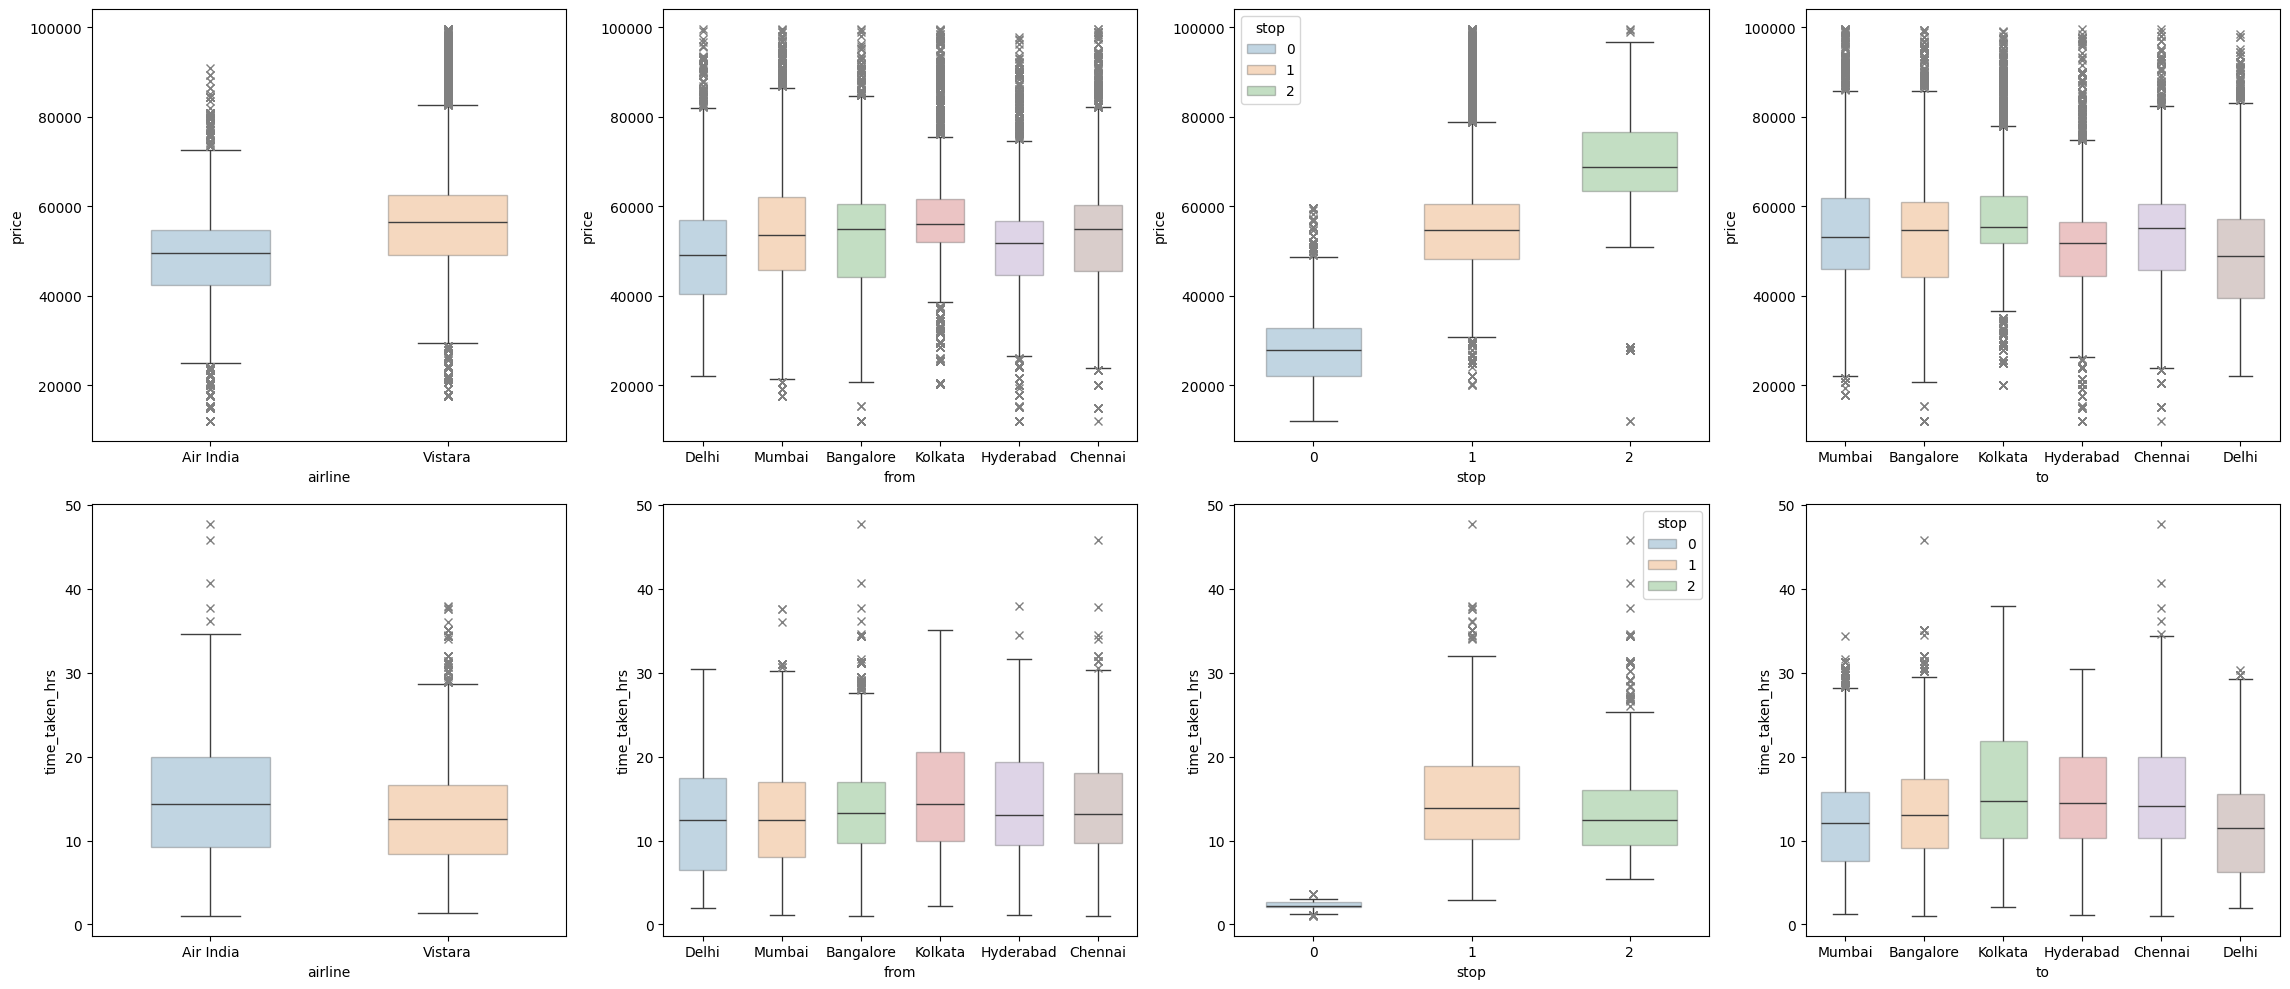

In [ ]:
get_graph_bi(busi_vis, "Business")

**<font color = 'green'>*Conclusiones analisis multivariante Business*</font>**



*   Airline: En la clase business, tanto el precio como el tiempo de viaje total no tienen distribuciones notablemente distintas entre las aerolíneas Vistara y Air India.
*   From: Las distribuciones de precio y tiempos de viaje total son similares entre las ciudades de inicio del viaje.
*   Stops: Aquí tenemos diferencias importantes, a mayor cantidad de paradas, presentan mayores rangos de precios, sin embargo, hay que tener en cuenta que la clase “2-stops”, tiene valores menores al 10%, por lo que hay que tomar esos resultados con mesura, a diferencia de 0 y 1 paradas los cuales tienen buena data como para poder aceptar conclusiones a partir de esa distribución.
*   To: El destino de viaje al igual que la ciudad de inicio, presentan distribuciones parejas entre los precios de los vuelos y el tiempo de viaje total, por lo que no se aprecian patrones nuevos al dividir por categoría.



**<font color = 'green'>*Analisis multivariante Economy*</font>**

Graficos del dataset Economy:



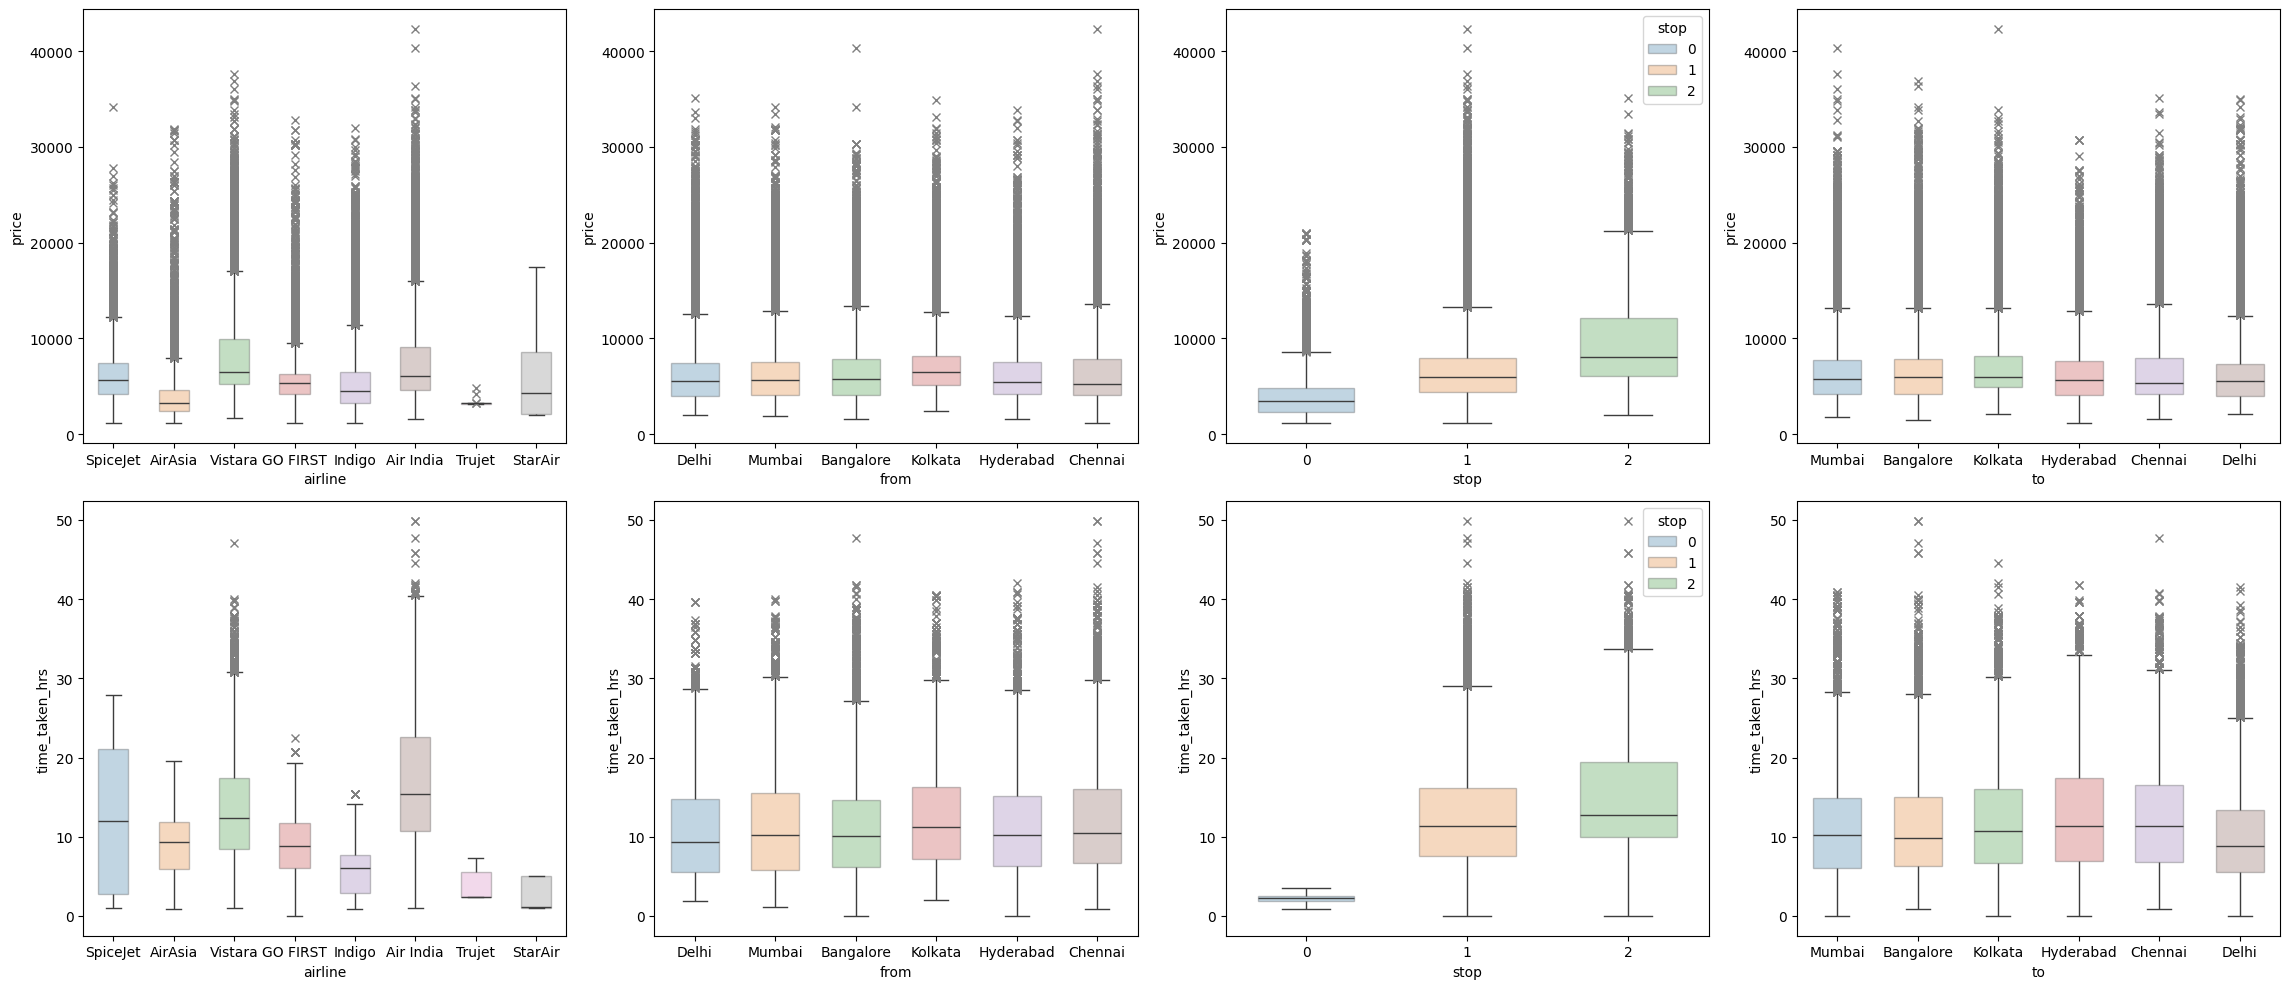

In [ ]:
get_graph_bi(eco_vis, "Economy")



*   Airline: A nivel de precios, en economy podemos ver que las 8 aerolinas distribuyen de manera sesgada a la derecha, por lo que tenemos excesivos outliers por sobre el limite superior. La categoria Trujet pareciera no tener una cantidad notable de registros como para ser relevante para concluir su comportamiento, al igual que StarAir. Con respecto a tiempos de vuelo, Estas 2 ultimas aerolineas nombradas cuentan con el 50% de sus tiempos de viaje de manera inferior ala resto de aerolineas, pero con muy pocos registros para ser relevante.
*   From: Tanto a nivel de precios como de tiempos, tambien se perciben distribuciones inferiores con respecto a business, pero de todas formas todas estas ciudades parecieran distribuir de manera similar sus datos. Se detectan excesivos outliers hacia el bigote superior.
*   Stops: En economy no detectamos una notable diferencia entre los precios y los tiempos con respecto a las paradas, sin embargo tambien cuentan con muchos outliers superiores
*   To: Al igual que en From, no se detectan diferencias significativas en la distribucion de esta variable contra el precio y el tiempo de vuelo en economy.Muchos outliers.





**Luego de esta revision de ambos productos del negocio Economy y Business y teniendo las conclusiones ya declaradas, procederemos a hacer una limpieza de outliers antes del analisis de correlaciones, ya que este ultimo es bien sensible a estos valores, además de esto, así dejaremos las variables numericas tentativamente listas para la modelacion o seleccion de caracteristicas significativas.**

**<font color = 'green'>*Limpieza de outliers*</font>**

In [ ]:
cols = ["price", "time_taken_hrs"]  # Columnas a limpiar



def clean_outliers(df, df_name, cols):

    df_clean = df.copy()  # Hacemos una copia del DataFrame original


    for colname in cols:  # Utilizaremos IQR ya que es mas robusto y no asume distribucion normal

        column_values = df_clean[colname].values

        Q1 = np.percentile(column_values, 25)

        Q3 = np.percentile(column_values, 75)

        IQR = Q3 - Q1

        LOWER = (Q1 - IQR * 1.5)

        UPPER = (Q3 + IQR * 1.5)


        # Extraemos los index que estan dentro de los parametros

        indices = (df_clean[colname].values >= LOWER) & (
            df_clean[colname].values <= UPPER)


        # Filtramos el df

        df_clean = df_clean[indices]


        shape_old = df.shape[0]

        shape_clean = df_clean.shape[0]


        print(
            f"El dataset {df_name} pasó de tener {shape_old} registros a tener {shape_clean} luego de la limpieza de outliers.")

    return df_clean

**Ejecutamos la limpieza sobre ambos datasets**

In [ ]:
clean_economy = clean_outliers(df_economy, "Economy", cols)

El dataset Economy pasó de tener 206772 registros a tener 193022 luego de la limpieza de outliers.
El dataset Economy pasó de tener 206772 registros a tener 191152 luego de la limpieza de outliers.


In [ ]:
clean_business = clean_outliers(df_businnes, "Business", cols)

El dataset Business pasó de tener 93379 registros a tener 89837 luego de la limpieza de outliers.
El dataset Business pasó de tener 93379 registros a tener 89742 luego de la limpieza de outliers.


#4.Realiza un análisis de correlaciones entre las diferentes variables existentes | 5. Realiza las transformaciones necesarias para realizar el modelamiento posterior y crea las variables que estimes convenientes.

Calcularemos la correlacion de Pearson entre variables numéricas y un test de ANOVA para testear entre las variables categoricas contra el target numerico.

In [ ]:
# Creamos algunas caracteristicas numericas extras para testear , extraemos el mes y el dia
df_businnes["month"] = df_businnes["date"].dt.month
df_businnes["day"] = df_businnes["date"].dt.day

df_economy["month"] = df_economy["date"].dt.month
df_economy["day"] = df_economy["date"].dt.day

**<font color = 'green'>*Pearson*</font>**

Text(0.5, 1.0, 'Correlación en Business')

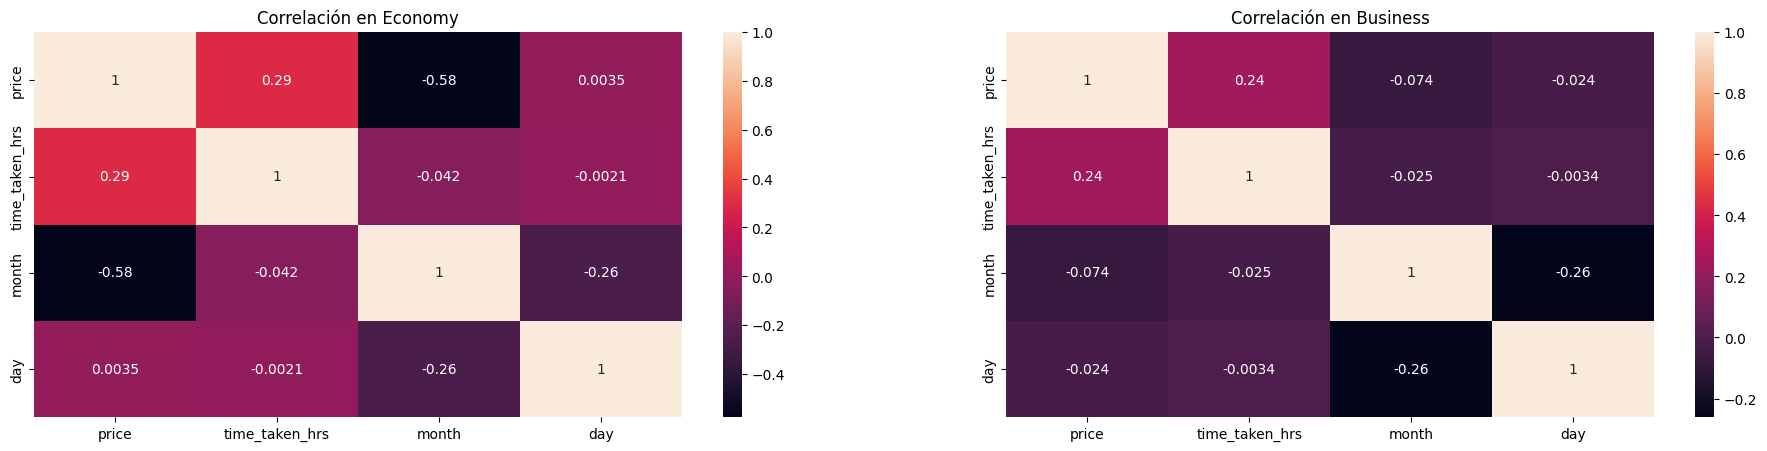

In [ ]:
# Calculamos la correlacion de pearson
pearson_economy = df_economy.corr(numeric_only=True)
pearson_businnes = df_businnes.corr(numeric_only=True)

# Graficamos las correlaciones de business y economy
fig, axes = plt.subplots(1, 2, figsize=(23, 5))

sns.heatmap(pearson_economy, annot=True, ax=axes[0])
axes[0].set_title("Correlación en Economy")
sns.heatmap(pearson_businnes, annot=True, ax=axes[1])
axes[1].set_title("Correlación en Business")

En economy, podemos ver que la correlacion positiva entre precio y tiempo de vuelo no es lo suficientemente grande para ser considerada una buena correlacion, sin embargo al no existir otras variables, se conservarán.

El mes, con una correlacion negativa de -0.58, en Economy pareciera ser una variable importante a considerar.

Interesante ver como cambian las correlaciones dependiendo del tipo de boleto entre economy y business, siendo algunas features más relevantes que otras.

Haremos una regresion lineal entre las variables numéricas para poder visualizar sus coeficientes de regresion y sus P-value y un test de ANOVA, ambos para aplicar test de hipotesís y verificar si estas caracteristicas son relevantes para predecir el precio.

**<font color = 'green'>*Regresion Lineal y OLS*</font>**

In [ ]:
X = df_businnes[["time_taken_hrs", "month", "day"]]
y = df_businnes["price"]

In [ ]:
def reglineal(X, y):
    # Paso 2: Agregar una constante (intercepto) a las variables predictoras
    X = sm.add_constant(X)

    # Paso 3: Crear el modelo de regresión lineal
    model = sm.OLS(y, X).fit()

    # Paso 4: Obtener resultados del modelo
    results = model.summary()

    predictions = model.predict(X)

    # Calcular el Error Cuadrático Medio (MSE)
    mse = ((y - predictions) ** 2).mean()

    # Calcular el Error Cuadrático Medio Explicado (EMSE)
    emse = mse / ((y - y.mean()) ** 2).mean()

    # Obtener el valor R² del modelo
    r2 = model.rsquared

    print(results)
    print("")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Error Mean Squared Explicado (EMSE): {emse:.2f}")
    print(f"Coeficiente de Determinación (R²): {r2:.2f}")

In [ ]:
reglineal(X, y)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     2204.
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:52:34   Log-Likelihood:            -1.0128e+06
No. Observations:               93379   AIC:                         2.026e+06
Df Residuals:                   93375   BIC:                         2.026e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.317e+04    290.650    182.

Observando tanto los coeficientes y los valores de P, podemos aceptar la hipotesis alternativa de que ambas variables estan relacionadas, sin embargo por si solas no son capaces de explicar la variablidad, por lo que ahora testearemos las variables categoricas para sumarlas y en los siguientes puntos, modelar.

**<font color = 'green'>*Test de ANOVA*</font>**

Crearemos columnas categoricas a partir de dep_time y arr_time, con el objetivo de entender como afecta la hora de llegada categorizandola, ya que antes era un datetime

In [ ]:
def categorize_hour(time_str):
    hour = int(time_str.split(":")[0])
    if hour < 6:
        return 'Madrugada'
    elif hour < 12:
        return 'Mañana'
    elif hour < 18:
        return 'Tarde'
    else:
        return 'Noche'


# Aplicamos la funcion a arr time y dep time
df_businnes['arr_time_cat'] = df_businnes['arr_time'].apply(categorize_hour)
df_economy['arr_time_cat'] = df_economy['arr_time'].apply(categorize_hour)

df_businnes['dep_time_cat'] = df_businnes['dep_time'].apply(categorize_hour)
df_economy['dep_time_cat'] = df_economy['dep_time'].apply(categorize_hour)

df_businnes = df_businnes.drop(columns=["dep_time", "arr_time"])
df_economy = df_economy.drop(columns=["dep_time", "arr_time"])

In [ ]:
# Definimos las features a testear
cat_features = df_economy[["airline", "fly_code",
                           "from", "to", "arr_time_cat", "dep_time_cat"]]
target = df_economy["price"]

# Iterar sobre cada característica categórica
for feature_name, feature_data in cat_features.items():
    # Agrupar los precios según las categorías únicas de la característica
    groups = [target[feature_data == category]
              for category in feature_data.unique()]

    # Realizar el test de ANOVA
    statistic, p_value = f_oneway(*groups)

    # Imprimir el resultado del test
    alpha = 0.05
    if p_value < alpha:
        print(
            f"El test de ANOVA para la característica '{feature_name}' es significativo; al menos un grupo es diferente.")
        print(f"P-value:", p_value)
        print()
    else:
        print(
            f"No hay evidencia suficiente para rechazar la hipótesis nula para la característica '{feature_name}'.")
        print(f"P-value:", p_value)
        print()

El test de ANOVA para la característica 'airline' es significativo; al menos un grupo es diferente.
P-value: 0.0

El test de ANOVA para la característica 'fly_code' es significativo; al menos un grupo es diferente.
P-value: 0.0

El test de ANOVA para la característica 'from' es significativo; al menos un grupo es diferente.
P-value: 0.0

El test de ANOVA para la característica 'to' es significativo; al menos un grupo es diferente.
P-value: 9.25044e-319

El test de ANOVA para la característica 'arr_time_cat' es significativo; al menos un grupo es diferente.
P-value: 0.0

El test de ANOVA para la característica 'dep_time_cat' es significativo; al menos un grupo es diferente.
P-value: 0.0



Luego del test de ANOVA, comprobamos que tanto las caracteristica iniciales, como las nuevas extraidas y creadas, son significativas para predecir el target, por lo que continuaremos en el punto 7 haciendo dummies para transformarlas a binarias.

# 6.Genera una función que encapsule el tratamiento de datos necesario, para entregar un dataset limpio y procesado a partir del dataset original.

Respuesta: Durante los puntos 1,2,3 y 4, solo se usaron funciones para filtrar ambos dataset, separadas por tematica de ejecución



*   funcion data_quality para revision de calidad de datos
*   funcion get_df_clean para limpieza y preprocesamiento de datos
*   funcion get_graphics_uni para analisis univariado
*   funcion get_graph_bi para analisis multivariado
*   funcion clean_outliers para limpieza de outliers.



Se generan de manera separada ya que en momentos solo es necesario ejecutar algunas partes, no una funcion completa.

# 7.Elige al menos 3 modelos candidatos para resolver el problema. A partir de esto, genera un conjunto de entrenamiento y prueba, para luego entrenar los diferentes modelos. | 8.Elige una grilla de hiperparametros y luego optimízalos, buscando la mejor combinación para cada grilla. Guardar los modelos entrenados.

Primero debemos transformar algunas variables con dummies, sin embargo no podemos conservar el fly code, ya que aumentaria la dimensionalidad del dataframe hasta 325 columnas. Unificaremos business y economy, agregando una columna que nos permita identificar a cual clase pertenece cada boleto. Esto con el objetivo de ejecutar un modelo con mayor data.

In [ ]:
# Creamos las clases como una sola columna boolean, para que en el dummies no la divida en 2
df_businnes["business"] = True

df_economy["business"] = False


flights = pd.concat([df_businnes, df_economy],
                    ignore_index=True)  # Concatenamos los df

In [ ]:
# Dropeamos el flycode y algunos date time que no usaremos en los modelos
flights_clean = flights.drop(columns=["fly_code", "date"])

# Creamos el df dummies
flights_dummies = pd.get_dummies(flights_clean)

In [ ]:
# Creamos las variables predictoras y objetivo
X = flights_dummies.drop(columns="price")
y = flights_dummies["price"]

**<font color = 'green'>*Forward Selection*</font>**

Haremos un forward selection para asegurarnos que la dimensionalidad del dataset entregado a los algoritmos permitan que convergan, no tomen tiempos computacionalmente excesivos y que se mantengan las features más relevantes y con estas modelar los algoritmos. Además, este primer modelo lo consideraremos el Base model para la comparacion en el punto 9.

In [ ]:
# Primero escalamos las variables

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Instanciamos un base model
estimator = LinearRegression()

# Creamos el objeto del forward
select = SequentialFeatureSelector(estimator, n_features_to_select=30, scoring="r2",
                                   direction="forward", cv=3)  # Hacemos validacion cruzada de 3 folds

# Ajustamos el selector
select.fit(X_scaled, y)

# Obtenemos los indices de las features seleccionadas
selected_index = select.get_support(indices=True)

# Extraemos los nombres de las features seleccionadas
selected_names = X.columns[selected_index]

# Filtramos el economy con las features seleccionadas
X_selected = X[selected_names]

**<font color = 'green'>*Modelo 1: Regresion lineal multiple*</font>**

In [ ]:
# Hacemos el train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=16)

# Instanciamoss
base_model = LinearRegression()


# Definimos una funcion para optimizar codigo adelante
def predict_metrics(model, X_train, X_test, y_train, y_test):
    # Ajustamos
    model.fit(X_train, y_train)

    # Realizamos predicciones en train y test
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculamos metricas de desempeño de train
    train_r2 = r2_score(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)

    # Calculamos metricas de desempeño de test
    test_r2 = r2_score(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)

    # ========================= OUTPUT =========================
    print("====================EVALUACION TRAIN ===============")
    print(f"Coeficiente de det. r2:", round(train_r2, 2))
    print(f"Mean Squared Error (MSE):", round(train_mse, 2))
    print(f"Root Mean Squared Error (RMSE):", round(train_rmse, 2))
    print()
    print("====================EVALUACION TEST===============")
    print(f"Coeficiente de det. r2:", round(test_r2, 2))
    print(f"Mean Squared Error (MSE):", round(test_mse, 2))
    print(f"Root Mean Squared Error (RMSE):", round(test_rmse, 2))

In [ ]:
predict_metrics(base_model, X_train, X_test, y_train, y_test)

====================EVALUACION TRAIN ===============
Coeficiente de det. r2: 0.91
Mean Squared Error (MSE): 44733864.52
Root Mean Squared Error (RMSE): 6688.34

====================EVALUACION TEST===============
Coeficiente de det. r2: 0.91
Mean Squared Error (MSE): 44519539.68
Root Mean Squared Error (RMSE): 6672.3


Al final, en el punto 9 se comentarán estos resultados*

**<font color = 'green'>*Modelo 2, 3 y 4: Ridge, Decision Tree Reg, Random Forest Reg*</font>**

Hacemos la búsqueda de hiperparametros para todos los modelos que queremos testear, aplicando cross validation de 5 folds sobre las features seleccionadas

In [ ]:
def get_grid(models, params, X_train, y_train):  # GRIDSEARCH
    best_models = {}
    for model_name, model in models.items():
        model_params = params[model_name]
        grid_search = GridSearchCV(model, model_params, cv=5)
        grid_search.fit(X_train, y_train)  # Ajustamos el modelo

        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_

        best_models[model_name] = {
            "best_params": best_params, "best_model": best_model}

        print("Best model for", model_name, ":", best_model)

    return best_models["Ridge"]

In [ ]:
def get_random_grid(models, params, X_train, y_train):  # RANDOMGRIDSEARCH
    best_models_trees = {}
    for model_name, model in models.items():
        model_params = params[model_name]
        random_search = RandomizedSearchCV(
            model, model_params, cv=5, n_iter=10)
        random_search.fit(X_train, y_train)  # Ajustamos el modelo

        best_params = random_search.best_params_
        best_model = random_search.best_estimator_

        best_models_trees[model_name] = {
            "best_params": best_params, "best_model": best_model}

        print("Best params for", model_name, ":", best_params)
        print("Best model for", model_name, ":", best_model)
        print("="*100)

    return best_models_trees

In [ ]:
# Modelos lineales a testear
linear_models = {'Ridge': Ridge()}

# Arboles a testear
decision_tree = {
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=16)}
random_forest = {'RandomForestRegressor': RandomForestRegressor(
    n_jobs=-1, random_state=16)}

# Parametros a testear en la grilla
linear_params = {'Ridge': {'alpha': [0.001, 0.1, 1.0, 5.0, 10, 20, 30]}}

tree_params = {'DecisionTreeRegressor': {'max_depth': [None, 10, 20, 30, 40, 50, 60],
                                         # Porcentaje
                                         'min_samples_split': [0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                                         # Porcentaje
                                         'min_samples_leaf': [0.025, 0.05, 0.1, 0.2],
                                         'max_features': ["sqrt", "log2"]
                                         }}


random_params = {'RandomForestRegressor': {'n_estimators': [2, 5, 10, 15, 20, 100],
                                           'max_depth': [None, 10, 20, 30, 40],
                                           # Porcentaje
                                           'min_samples_split': [0.025, 0.05, 0.1, 0.2],
                                           'min_samples_leaf': [0.025, 0.05, 0.1, 0.2]}}  # Porcentaje

**Ejecutamos la grilla para los modelos lineales a través de GridSearch y los arboles a través de RandomSearch**

In [ ]:
# Ejecutamos la funcion para el modelo lineal
best_params_ridge = get_grid(linear_models, linear_params, X_train, y_train)

Best model for Ridge : Ridge(alpha=0.1)


In [ ]:
# Ejecutamos la funcion para el decision tree regresor
best_params_dt = get_random_grid(decision_tree, tree_params, X_train, y_train)

Best params for DecisionTreeRegressor : {'min_samples_split': 0.6, 'min_samples_leaf': 0.025, 'max_features': 'sqrt', 'max_depth': 30}
Best model for DecisionTreeRegressor : DecisionTreeRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=0.025,
                      min_samples_split=0.6, random_state=16)


In [ ]:
# Ejecutamos la funcion para el random forest
best_params_rf = get_random_grid(
    random_forest, random_params, X_train, y_train)

Best params for RandomForestRegressor : {'n_estimators': 15, 'min_samples_split': 0.025, 'min_samples_leaf': 0.025, 'max_depth': 40}
Best model for RandomForestRegressor : RandomForestRegressor(max_depth=40, min_samples_leaf=0.025,
                      min_samples_split=0.025, n_estimators=15, n_jobs=-1,
                      random_state=16)


In [ ]:
# Creamos los modelos con los mejores hiperparametros
ridge = Ridge(alpha=0.1)
dt = DecisionTreeRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=0.025,
                           min_samples_split=0.6, random_state=16)

rf = RandomForestRegressor(max_depth=40, min_samples_leaf=0.025,
                           min_samples_split=0.025, n_estimators=15, n_jobs=-1,
                           random_state=16)

Predicciones de los 3 modelos y comparacion de resultados en el punto 9.

# 9.Define al menos 3 métricas para evaluar los modelos entrenados y genera gráficos de comparación. Elige un baseline para ver qué tan buena es tu opción respecto a ese baseline y concluye.

El base line escogido será la regresion lineal simple, ya que es el modelo más básico posible y que no se caracteriza principalmente por comprender las relaciones no lineales, además, al ser de los más simples, no contiene realmente muchos parametros a testear en la busqueda de hiperparametros, por lo que lo consideraremos como un buen baseline.

In [ ]:
# Metricas del base model, regresion lineal multiple
predict_metrics(base_model, X_train, X_test, y_train, y_test)

====================EVALUACION TRAIN ===============
Coeficiente de det. r2: 0.91
Mean Squared Error (MSE): 44733864.52
Root Mean Squared Error (RMSE): 6688.34

====================EVALUACION TEST===============
Coeficiente de det. r2: 0.91
Mean Squared Error (MSE): 44519539.68
Root Mean Squared Error (RMSE): 6672.3


In [ ]:
predict_metrics(ridge, X_train, X_test, y_train, y_test)  # Metricas de Ridge

====================EVALUACION TRAIN ===============
Coeficiente de det. r2: 0.91
Mean Squared Error (MSE): 44733864.56
Root Mean Squared Error (RMSE): 6688.34

====================EVALUACION TEST===============
Coeficiente de det. r2: 0.91
Mean Squared Error (MSE): 44519538.03
Root Mean Squared Error (RMSE): 6672.3


In [ ]:
# Metricas decision tree regressor
predict_metrics(dt, X_train, X_test, y_train, y_test)

====================EVALUACION TRAIN ===============
Coeficiente de det. r2: 0.13
Mean Squared Error (MSE): 448274397.31
Root Mean Squared Error (RMSE): 21172.49

====================EVALUACION TEST===============
Coeficiente de det. r2: 0.13
Mean Squared Error (MSE): 447075529.55
Root Mean Squared Error (RMSE): 21144.16


In [ ]:
# Metricas decision Random forest regressor
predict_metrics(rf, X_train, X_test, y_train, y_test)

====================EVALUACION TRAIN ===============
Coeficiente de det. r2: 0.93
Mean Squared Error (MSE): 36197284.77
Root Mean Squared Error (RMSE): 6016.42

====================EVALUACION TEST===============
Coeficiente de det. r2: 0.93
Mean Squared Error (MSE): 36262569.81
Root Mean Squared Error (RMSE): 6021.84


**Crearemos los graficos**

In [ ]:

  # =================LINEAR REGRESSION ===========

  #Realizamos predicciones en train y test por cada modelo
  y_pred_train = base_model.predict(X_train)
  y_pred_test = base_model.predict(X_test)

  #Calculamos metricas de desempeño de train por cada modelo
  train_r2_lineal = r2_score (y_train,y_pred_train)
  train_mse_lineal = mean_squared_error(y_train,y_pred_train)
  train_rmse_lineal = np.sqrt(train_mse_lineal)

  #Calculamos metricas de desempeño de test por cada modelo
  test_r2_lineal = r2_score (y_test,y_pred_test)
  test_mse_lineal = mean_squared_error(y_test,y_pred_test)
  test_rmse_lineal = np.sqrt(test_mse_lineal)

  row_lineal = pd.DataFrame({"Model": "LinearRegression",
                "TRAIN_r2": train_r2_lineal,
                "TRAIN_mse" : train_mse_lineal,
                "TRAIN_RMSE": train_rmse_lineal,
                "TEST_r2": test_r2_lineal,
                "TEST_mse": test_mse_lineal,
                "TEST_RMSE": test_rmse_lineal
                },index=[0])

  # =================RIDGE ===========

  #Realizamos predicciones en train y test por cada modelo
  y_pred_train = ridge.predict(X_train)
  y_pred_test = ridge.predict(X_test)

  #Calculamos metricas de desempeño de train por cada modelo
  train_r2_ridge = r2_score (y_train,y_pred_train)
  train_mse_ridge = mean_squared_error(y_train,y_pred_train)
  train_rmse_ridge = np.sqrt(train_mse_ridge)

  #Calculamos metricas de desempeño de test por cada modelo
  test_r2_ridge = r2_score (y_test,y_pred_test)
  test_mse_ridge = mean_squared_error(y_test,y_pred_test)
  test_rmse_ridge = np.sqrt(test_mse_ridge)

  row_ridge = pd.DataFrame({"Model": "Ridge",
                "TRAIN_r2": train_r2_ridge,
                "TRAIN_mse" : train_mse_ridge,
                "TRAIN_RMSE": train_rmse_ridge,
                "TEST_r2": test_r2_ridge,
                "TEST_mse": test_mse_ridge,
                "TEST_RMSE": test_rmse_ridge
                },index=[0])

   # =================DECISION TREE ===========

  #Realizamos predicciones en train y test por cada modelo
  y_pred_train = dt.predict(X_train)
  y_pred_test = dt.predict(X_test)

  #Calculamos metricas de desempeño de train por cada modelo
  train_r2_dt = r2_score (y_train,y_pred_train)
  train_mse_dt = mean_squared_error(y_train,y_pred_train)
  train_rmse_dt = np.sqrt(train_mse_dt)

  #Calculamos metricas de desempeño de test por cada modelo
  test_r2_dt = r2_score (y_test,y_pred_test)
  test_mse_dt = mean_squared_error(y_test,y_pred_test)
  test_rmse_dt = np.sqrt(test_mse_dt)

  row_decision = pd.DataFrame({"Model": "DecisionTreeRegressor",
                "TRAIN_r2": train_r2_dt,
                "TRAIN_mse" : train_mse_dt,
                "TRAIN_RMSE": train_rmse_dt,
                "TEST_r2": test_r2_dt,
                "TEST_mse": test_mse_dt,
                "TEST_RMSE": test_rmse_dt
                },index=[0])


   # =================RANDOM FOREST ===========

  #Realizamos predicciones en train y test por cada modelo
  y_pred_train = rf.predict(X_train)
  y_pred_test = rf.predict(X_test)

  #Calculamos metricas de desempeño de train por cada modelo
  train_r2_rf = r2_score (y_train,y_pred_train)
  train_mse_rf = mean_squared_error(y_train,y_pred_train)
  train_rmse_rf = np.sqrt(train_mse_rf)

  #Calculamos metricas de desempeño de test por cada modelo
  test_r2_rf = r2_score (y_test,y_pred_test)
  test_mse_rf = mean_squared_error(y_test,y_pred_test)
  test_rmse_rf = np.sqrt(test_mse_rf)

  row_random = pd.DataFrame({"Model": "RandomForest",
                "TRAIN_r2": train_r2_rf,
                "TRAIN_mse" : train_mse_rf,
                "TRAIN_RMSE": train_rmse_rf,
                "TEST_r2": test_r2_rf,
                "TEST_mse": test_mse_rf,
                "TEST_RMSE": test_rmse_rf
                },index=[0])

  #Concatenamos los resultados
df_comparation = pd.concat([row_lineal,row_ridge,row_decision,row_random],ignore_index=True)
df_comparation = df_comparation.round(2)
df_comparation

,Model,TRAIN_r2,TRAIN_mse,TRAIN_RMSE,TEST_r2,TEST_mse,TEST_RMSE
0,LinearRegression,0.91,4.473386e+07,6688.34,0.91,4.451954e+07,6672.30
1,Ridge,0.91,4.473386e+07,6688.34,0.91,4.451954e+07,6672.30
2,DecisionTreeRegressor,0.13,4.482744e+08,21172.49,0.13,4.470755e+08,21144.16
3,RandomForest,0.93,3.619728e+07,6016.42,0.93,3.626257e+07,6021.84


Graficaremos

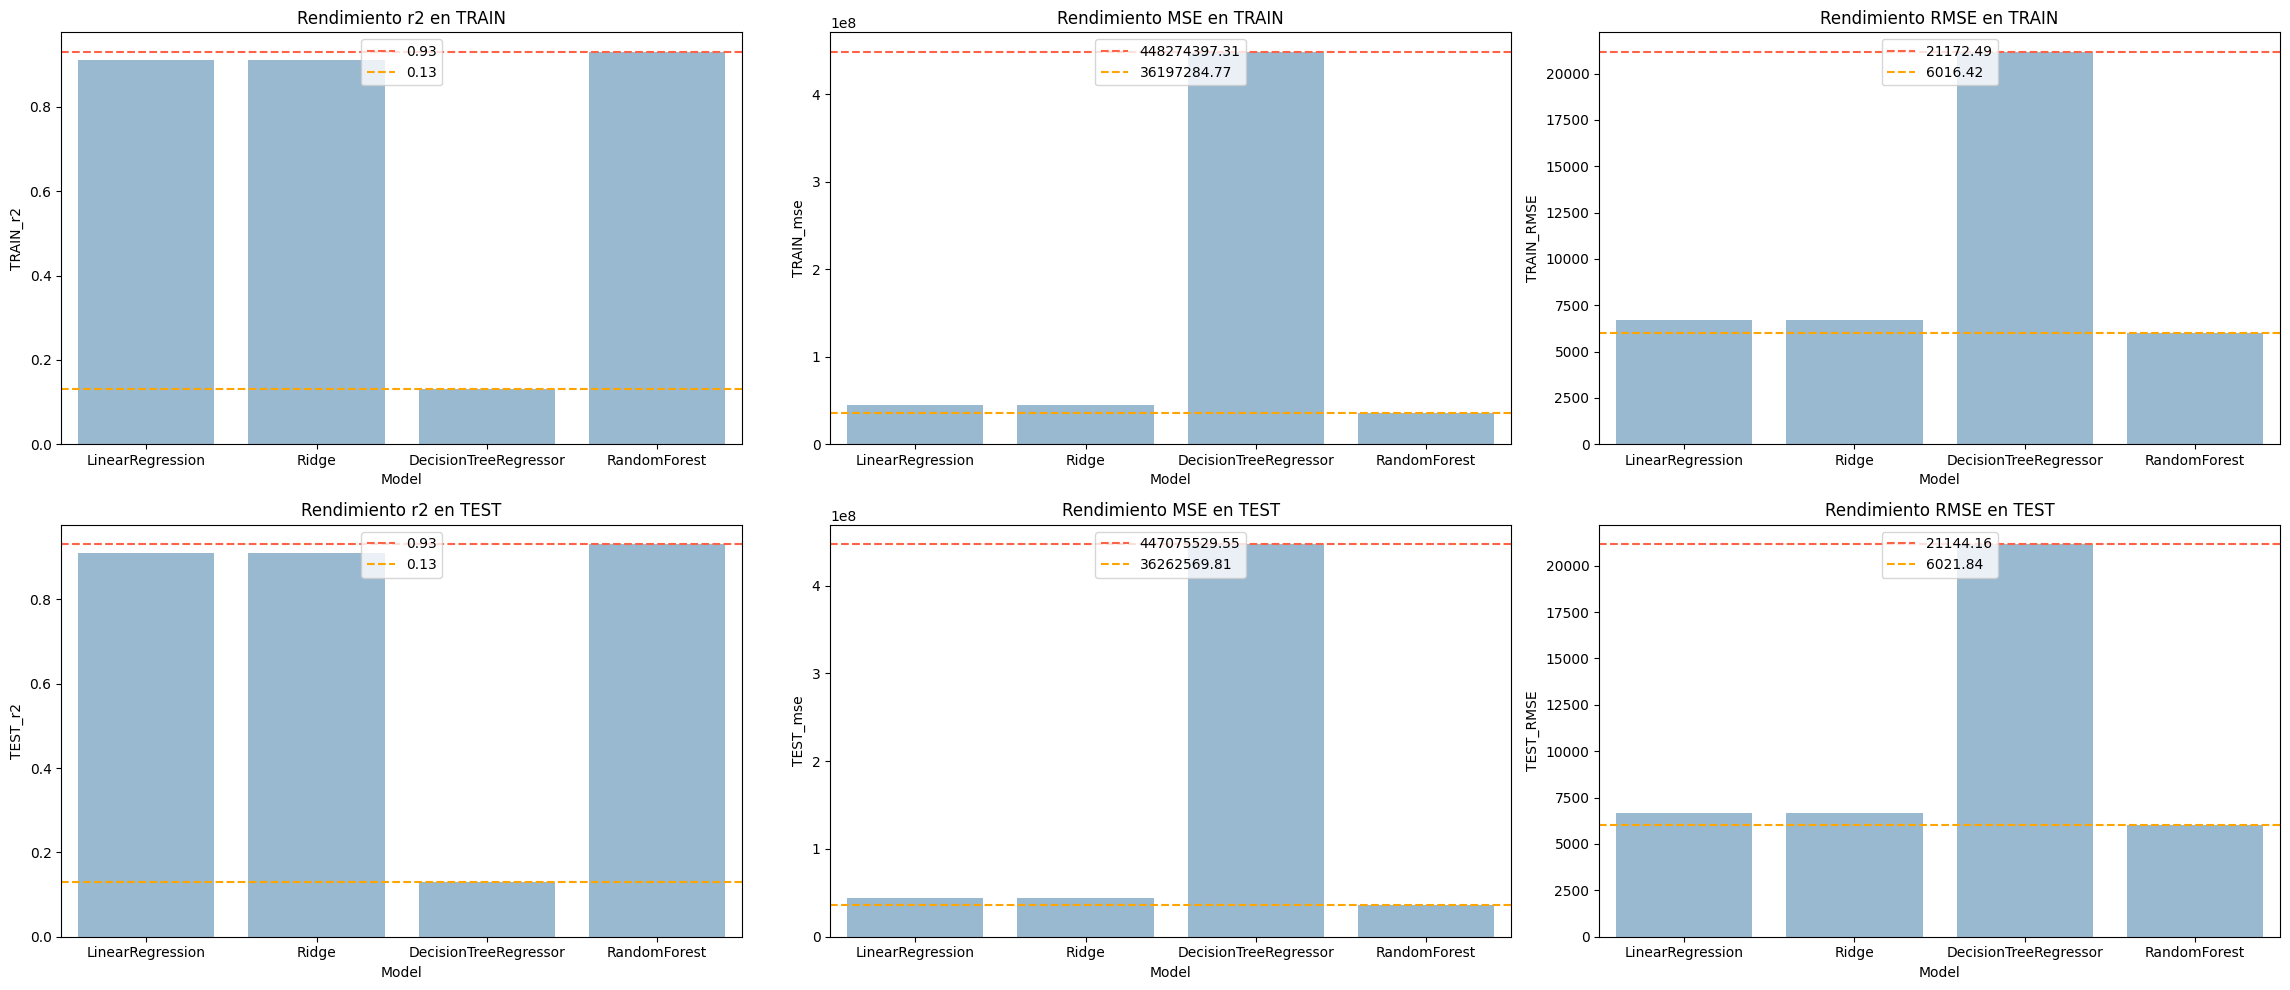

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(23, 10))

# Train r2
sns.barplot(data=df_comparation, x="Model",
            y="TRAIN_r2", ax=axes[0, 0], alpha=0.5)
axes[0, 0].axhline(df_comparation["TRAIN_r2"].max(
), label=df_comparation["TRAIN_r2"].max(), ls="dashed", color="tomato")
axes[0, 0].axhline(df_comparation["TRAIN_r2"].min(
), label=df_comparation["TRAIN_r2"].min(), ls="dashed", color="orange")
axes[0, 0].set_title("Rendimiento r2 en TRAIN")
axes[0, 0].legend(loc="upper center")

# TRAIN mse
sns.barplot(data=df_comparation, x="Model",
            y="TRAIN_mse", ax=axes[0, 1], alpha=0.5)
axes[0, 1].axhline(df_comparation["TRAIN_mse"].max(
), label=df_comparation["TRAIN_mse"].max(), ls="dashed", color="tomato")
axes[0, 1].axhline(df_comparation["TRAIN_mse"].min(
), label=df_comparation["TRAIN_mse"].min(), ls="dashed", color="orange")
axes[0, 1].set_title("Rendimiento MSE en TRAIN")
axes[0, 1].legend(loc="upper center")

# TRAIN rmse
sns.barplot(data=df_comparation, x="Model",
            y="TRAIN_RMSE", ax=axes[0, 2], alpha=0.5)
axes[0, 2].axhline(df_comparation["TRAIN_RMSE"].max(
), label=df_comparation["TRAIN_RMSE"].max(), ls="dashed", color="tomato")
axes[0, 2].axhline(df_comparation["TRAIN_RMSE"].min(
), label=df_comparation["TRAIN_RMSE"].min(), ls="dashed", color="orange")
axes[0, 2].set_title("Rendimiento RMSE en TRAIN")
axes[0, 2].legend(loc="upper center")

# TEST r2
sns.barplot(data=df_comparation, x="Model",
            y="TEST_r2", ax=axes[1, 0], alpha=0.5)
axes[1, 0].axhline(df_comparation["TEST_r2"].max(
), label=df_comparation["TEST_r2"].max(), ls="dashed", color="tomato")
axes[1, 0].axhline(df_comparation["TEST_r2"].min(
), label=df_comparation["TEST_r2"].min(), ls="dashed", color="orange")
axes[1, 0].set_title("Rendimiento r2 en TEST")
axes[1, 0].legend(loc="upper center")

# TEST mse
sns.barplot(data=df_comparation, x="Model",
            y="TEST_mse", ax=axes[1, 1], alpha=0.5)
axes[1, 1].axhline(df_comparation["TEST_mse"].max(
), label=df_comparation["TEST_mse"].max(), ls="dashed", color="tomato")
axes[1, 1].axhline(df_comparation["TEST_mse"].min(
), label=df_comparation["TEST_mse"].min(), ls="dashed", color="orange")
axes[1, 1].set_title("Rendimiento MSE en TEST")
axes[1, 1].legend(loc="upper center")

# TEST RMSE
sns.barplot(data=df_comparation, x="Model",
            y="TEST_RMSE", ax=axes[1, 2], alpha=0.5)
axes[1, 2].axhline(df_comparation["TEST_RMSE"].max(
), label=df_comparation["TEST_RMSE"].max(), ls="dashed", color="tomato")
axes[1, 2].axhline(df_comparation["TEST_RMSE"].min(
), label=df_comparation["TEST_RMSE"].min(), ls="dashed", color="orange")
axes[1, 2].set_title("Rendimiento RMSE en TEST")
axes[1, 2].legend(loc="upper center")

plt.tight_layout()
plt.show()

# 10.Genera una conclusión final respecto a qué tan útiles son los resultados encontrados para resolver el problema propuesto y define cuáles podrían ser los próximos pasos para el proyecto.

Conclusiones finales: Considerando las metricas de desempeño de la regresion lineal como base model, el cual tuvo un r2 de 0,91 lo que describe que el modelo es capaz de explicar el 91% de la variabilidad del precio de los boletos, un mse de 44519539.68 y un rmse de 6672.3, los cuales no son errores grandes si los comparamos con la desviacion estandar de 22000 que presentan los valores de los boletos, a pesar de que es un buen modelo base, se lograron aún mejores metricas con un random forest, logrando aumentar el r2 a 0.93 y disminuir el RMSE casi 600 unidades con respecto al base model, lo cual indica que ambos modelos son capaces y validos para desarrollar un MVP para la predicción del precio de los boletos. Debido a que utilizamos Forward selection para la seleccion de caracteristicas importantes es que no se testearon algoritmos como Lasso, ya que en la preseleccion ya se penalizaron algunas. Sobre las metricas del arbol de decision, a pesar de iterar sobre sus hiperparametros durante bastante tiempo, el modelo no logró capturar la variablidad del target, teniendo r2 bajo 0.20 y errores excesivamente altos, en comparacion con los buenos rendimientos de los otros algoritmos. Otro punto importante a indicar es que ninguno de los modelos presenta overfitting ni underfitting, lo que indica que tanto el preprocesamiento como la seleccion de variables esstuvo correcta para capturar la complejidad de los datos a modelar.

Los siguientes pasos podrian ser obtener otro tipo de datos que sean importantes para predecir el precio de los boletos, como obtener informacion sobre otros continentes, paises, aerolineas, capacidad del avión e incluso otros factores más mecanicos que podrían afectar, como el rendimiento promedio de consumo del avión, ya que esto afecta el costo del vuelo a la empresa, quiza obtener la fecha de compra del ticket vs la fecha del vuelo, ya que mientras más cerca del vuelo es más caro el boleto. Con esas nuevas features se podría "complejizar" un poco más el modelo y obtener otro tipo de mirada hacía el mismo problema y por ejemplo, en base a esa predicción, saber si un nuevo modelo de avión basado en esas caracteristicas puede ser una buena opcion para el negocio, calculando los precios de los boletos y el retorno.